In [2]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Convolution2D
from keras.layers import Lambda, Add, Reshape, Activation
from keras.models import Model
import tensorflow as tf

Using TensorFlow backend.


In [3]:
# The number of output labels
nb_labels = 6

# The dimensions of the input images
nb_rows = 256
nb_cols = 256

In [4]:
# A ResNet model with weights from training on ImageNet. This will
# be adapted via graph surgery into an FCN.
base_model = ResNet50(
    include_top=True, weights='imagenet', input_tensor=None)

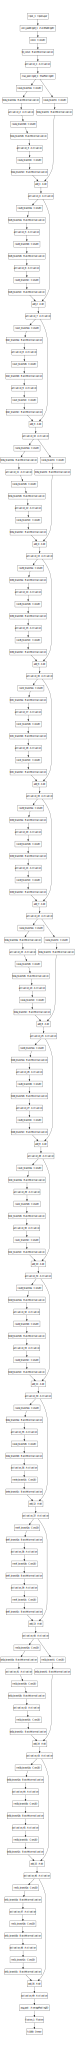

In [5]:
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
#plot_model(model,'model.png')
#res=layer1.(test_image)

SVG(model_to_dot(base_model).create(prog='dot',format='svg'))

In [6]:
#base_model.weights

In [10]:
# Get final 32x32, 16x16, and 8x8 layers in the original
# ResNet by that layers's name.
x32 = base_model.get_layer('res5c_branch2b').output
x16 = base_model.get_layer('res3a_branch2a').output
x8 = base_model.get_layer('res5a_branch2b').output

# Compress each skip connection so it has nb_labels channels.
c32 = Convolution2D(nb_labels, (1, 1))(x32)
c16 = Convolution2D(nb_labels, (1, 1))(x16)
c8 = Convolution2D(nb_labels, (1, 1))(x8)

In [11]:
# Resize each compressed skip connection using bilinear interpolation.
# This operation isn't built into Keras, so we use a LambdaLayer
# which allows calling a Tensorflow operation.
def resize_bilinear(images):
    return tf.image.resize_bilinear(images, [nb_rows, nb_cols])

r32 = Lambda(resize_bilinear)(c32)
r16 = Lambda(resize_bilinear)(c16)
r8 = Lambda(resize_bilinear)(c8)

# Merge the three layers together using summation.
m = Add()([r32, r16, r8])

# Add softmax layer to get probabilities as output. We need to reshape
# and then un-reshape because Keras expects input to softmax to
# be 2D.
x = Reshape((nb_rows * nb_cols, nb_labels))(m)
x = Activation('softmax')(x)
x = Reshape((nb_rows, nb_cols, nb_labels))(x)

fcn_model = Model(input=input_tensor, output=x)

NameError: name 'input_tensor' is not defined

In [9]:
"""
ResNet based FCN.
"""
from keras.models import Model
from keras.layers import (
    Input, Activation, Reshape, Conv2D, Lambda, Add)
import tensorflow as tf



FCN_RESNET = 'fcn_resnet'


def make_fcn_resnet(input_shape, nb_labels, use_pretraining, freeze_base):
    nb_rows, nb_cols, _ = input_shape
    input_tensor = Input(shape=input_shape)
    weights = 'imagenet' if use_pretraining else None

    model = ResNet50(
        include_top=False, weights=weights, input_tensor=input_tensor)

    if freeze_base:
        for layer in model.layers:
            layer.trainable = False

    x32 = model.get_layer('act3d').output
    x16 = model.get_layer('act4f').output
    x8 = model.get_layer('act5c').output

    c32 = Conv2D(nb_labels, (1, 1), name='conv_labels_32')(x32)
    c16 = Conv2D(nb_labels, (1, 1), name='conv_labels_16')(x16)
    c8 = Conv2D(nb_labels, (1, 1), name='conv_labels_8')(x8)

    def resize_bilinear(images):
        return tf.image.resize_bilinear(images, [nb_rows, nb_cols])

    r32 = Lambda(resize_bilinear, name='resize_labels_32')(c32)
    r16 = Lambda(resize_bilinear, name='resize_labels_16')(c16)
    r8 = Lambda(resize_bilinear, name='resize_labels_8')(c8)

    m = Add(name='merge_labels')([r32, r16, r8])

    x = Reshape((nb_rows * nb_cols, nb_labels))(m)
    x = Activation('softmax')(x)
    x = Reshape((nb_rows, nb_cols, nb_labels))(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model

In [38]:
make_fcn_resnet(, 6, True, False)

ValueError: not enough values to unpack (expected 3, got 2)

In [32]:
# import the necessary packages
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import Xception # TensorFlow ONLY
from keras.applications import VGG16
from keras.applications import VGG19
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import argparse
import cv2

In [33]:
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True, help="path to the input image")
ap.add_argument("-model", "--model", type=str, default="vgg16", help="name of pre-trained network to use")
args = vars(ap.parse_args())


# define a dictionary that maps model names to their classes
# inside Keras
MODELS = {
    "vgg16": VGG16,
    "vgg19": VGG19,
    "inception": InceptionV3,
    "xception": Xception, # TensorFlow ONLY
    "resnet": ResNet50
    }
 
# esnure a valid model name was supplied via command line argument
if args["model"] not in MODELS.keys():
    raise AssertionError("The --model command line argument should "
        "be a key in the `MODELS` dictionary")
    
 
"""
A Convolutional Neural Network takes an image as an input and then returns a set of probabilities corresponding to the class labels as output.

Typical input image sizes to a Convolutional Neural Network trained on ImageNet are 224×224, 227×227, 256×256, and 299×299; however, you may see other dimensions as well.

VGG16, VGG19, and ResNet all accept 224×224 input images while Inception V3 and Xception require 299×299 pixel inputs, as demonstrated by the following code block:
"""

# initialize the input image shape (224x224 pixels) along with
# the pre-processing function (this might need to be changed
# based on which model we use to classify our image)
inputShape = (224, 224)
preprocess = imagenet_utils.preprocess_input
 
# if we are using the InceptionV3 or Xception networks, then we
# need to set the input shape to (299x299) [rather than (224x224)]
# and use a different image processing function
if args["model"] in ("inception", "xception"):
    inputShape = (299, 299)
    preprocess = preprocess_input
    
    
# load our the network weights from disk (NOTE: if this is the
# first time you are running this script for a given network, the
# weights will need to be downloaded first -- depending on which
# network you are using, the weights can be 90-575MB, so be
# patient; the weights will be cached and subsequent runs of this
# script will be *much* faster)
print("[INFO] loading {}...".format(args["model"]))
Network = MODELS[args["model"]]
model = Network(weights="imagenet")

# load the input image using the Keras helper utility while ensuring
# the image is resized to `inputShape`, the required input dimensions
# for the ImageNet pre-trained network
print("[INFO] loading and pre-processing image...")
image = load_img(args["image"], target_size=inputShape)
image = img_to_array(image)
 
# our input image is now represented as a NumPy array of shape
# (inputShape[0], inputShape[1], 3) however we need to expand the
# dimension by making the shape (1, inputShape[0], inputShape[1], 3)
# so we can pass it through the network
image = np.expand_dims(image, axis=0)
 
# pre-process the image using the appropriate function based on the
# model that has been loaded (i.e., mean subtraction, scaling, etc.)
image = preprocess(image)

# classify the image
print("[INFO] classifying image with '{}'...".format(args["model"]))
preds = model.predict(image)
P = imagenet_utils.decode_predictions(preds)
 
# loop over the predictions and display the rank-5 predictions +
# probabilities to our terminal
for (i, (imagenetID, label, prob)) in enumerate(P[0]):
    print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))
    
# load the image via OpenCV, draw the top prediction on the image,
# and display the image to our screen
orig = cv2.imread(args["image"])
(imagenetID, label, prob) = P[0][0]
cv2.putText(orig, "Label: {}, {:.2f}%".format(label, prob * 100),
    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
cv2.imshow("Classification", orig)
cv2.waitKey(0)


usage: ipykernel_launcher.py [-h] -i IMAGE [-model MODEL]
ipykernel_launcher.py: error: the following arguments are required: -i/--image


SystemExit: 2

/apps/chpc/bio/python/3.6.0_gcc-6.3.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [34]:
with open("model.json", "r") as f:
    json_file = f.read()
    model = keras.models.model_from_json(json_file)

FileNotFoundError: [Errno 2] No such file or directory: 'model.json'